# Multi Label Classification

In [27]:
import scipy.io as sio
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score
from gensim.models import Word2Vec, KeyedVectors
import multiprocessing
import sys
import datetime
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", level=logging.INFO)

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
print(cores)

8


In [28]:
# load a .mat file into a numpy array
def load_mat(filename):
    data = sio.loadmat(filename)
    # return data['data']
    return data

In [29]:
# Step 1: load the embeddings from word_2_vec format using keyedvectors
model_dw = KeyedVectors.load_word2vec_format('../embeddings/flickr_dw.txt', binary=False)
# model_n2v = KeyedVectors.load_word2vec_format('../embeddings/flickr_n2v.txt', binary=False)
print(model_dw)
# print(model_n2v)

INFO - 2023-11-28 12:06:33,249: loading projection weights from ../embeddings/flickr_dw.txt
INFO - 2023-11-28 12:06:37,135: KeyedVectors lifecycle event {'msg': 'loaded (80513, 128) matrix of type float32 from ../embeddings/flickr_dw.txt', 'binary': False, 'encoding': 'utf8', 'datetime': '2023-11-28T12:06:37.135423', 'gensim': '4.3.2', 'python': '3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]', 'platform': 'Linux-5.15.0-88-generic-x86_64-with-glibc2.31', 'event': 'load_word2vec_format'}


KeyedVectors<vector_size=128, 80513 keys>


In [30]:
# Step 2: Also obtain the labels
data_np = load_mat('../datasets/flickr.mat')
labels_one_hot = data_np['group'].toarray()

print(labels_one_hot.shape)     # (10312, 39)

'''Now we know that the labels are one-hot encoded'''
label_sample = labels_one_hot[100]      # Thus, each node can have multiple labels (indicated by 2 ones in the array)
print(label_sample)

(80513, 195)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


In [31]:
# define the classification model: One vs rest classifier -> Obtained from ChatGPT
class TopKRanker(OneVsRestClassifier):
    def __init__(self, estimator=None):
        super(TopKRanker, self).__init__(estimator=estimator)

    def predict(self, X, top_k_list):
        assert X.shape[0] == len(top_k_list)
        probs = np.asarray(super(TopKRanker, self).predict_proba(X))
        all_labels = []
        for i, k in enumerate(top_k_list):
            probs_ = probs[i, :]
            labels = np.argsort(probs_)[-k:].tolist()  # Get indices of top k labels
            all_labels.append(labels)
        return all_labels


In [32]:
training_fraction = [0.1,0.2, 0.3, 0.4, 0.5,0.6, 0.7,0.8, 0.9]
dataset_size = labels_one_hot.shape[0]
embedding_dim = 128

micro_f1_scores_dw = []
macro_f1_scores_dw = []

# micro_f1_scores_n2v = []
# macro_f1_scores_n2v = []

# loop through the training fractions and see how micro and macro F1 scores change -> autocompleted by copilot
for fraction in training_fraction:
    # Step 3: Shuffle the dataset
    np.random.seed(0)
    indices = np.arange(dataset_size)
    np.random.shuffle(indices)

    # Step 4: Obtain the training and testing indices
    training_size = int(dataset_size * fraction)
    test_size = dataset_size - training_size
    training_indices = indices[:training_size]
    testing_indices = indices[training_size:]

    # Step 4.1: Initialize empty matrices for X_train and X_test: dw and n2v
    X_train_dw = np.zeros((training_size, embedding_dim))  # 'train_size' is the size of our training set
    X_test_dw = np.zeros((test_size, embedding_dim))    # 'test_size' is the size of our test set

    # X_train_n2v = np.zeros((training_size, embedding_dim))  # 'train_size' is the size of our training set
    # X_test_n2v = np.zeros((test_size, embedding_dim))    # 'test_size' is the size of our test set

        # We need to populate 'train_indices' and 'test_indices' based on our train/test split

    # Populate X_train with embeddings for train set nodes
    for i, node_index in enumerate(training_indices):
        if str(node_index) in model_dw:
            X_train_dw[i] = model_dw[str(node_index)]
            # X_train_n2v[i] = model_n2v[str(node_index)]

    # Populate X_test with embeddings for test set nodes
    for i, node_index in enumerate(testing_indices):
        if str(node_index) in model_dw:
            X_test_dw[i] = model_dw[str(node_index)]
            # X_test_n2v[i] = model_n2v[str(node_index)]

    # Step 4.2: Obtain the training and testing labels
    y_train = labels_one_hot[training_indices]
    y_test = labels_one_hot[testing_indices]

    print("sample y_train:",y_train[0])
    # Step 5: Change the labels to a list of labels for OnevsRestClassifier
    train_labels = []
    test_labels = []
    for i in range(y_train.shape[0]):
        train_labels.append(np.where(y_train[i] == 1)[0].tolist())
    for i in range(y_test.shape[0]):
        test_labels.append(np.where(y_test[i] == 1)[0].tolist())

    #---------------    DeepWalk    ------------------#
    # Step 6: Train the classifier
    classifier_dw = TopKRanker(LogisticRegression())
    # classifier.fit(X_train, train_labels)
    classifier_dw.fit(X_train_dw, y_train)

    # Step 7: Obtain the predictions
    predictions = classifier_dw.predict(X_test_dw, top_k_list=[len(l) for l in test_labels])

    # Step 8: Calculate the micro and macro F1 scores
    mlb = MultiLabelBinarizer(classes=np.arange(195))
    binary_predictions = mlb.fit_transform(predictions)
    micro_f1 = f1_score(y_test, binary_predictions, average='micro')
    macro_f1 = f1_score(y_test, binary_predictions, average='macro')

    micro_f1_scores_dw.append(micro_f1)
    macro_f1_scores_dw.append(macro_f1)

    #---------------    Node2Vec    ------------------#
    # Step 6: Train the classifier
    # classifier_n2v = TopKRanker(LogisticRegression())
    # # classifier.fit(X_train, train_labels)
    # classifier_n2v.fit(X_train_n2v, y_train)

    # # Step 7: Obtain the predictions
    # predictions = classifier_n2v.predict(X_test_n2v, top_k_list=[len(l) for l in test_labels])

    # # Step 8: Calculate the micro and macro F1 scores
    # mlb = MultiLabelBinarizer(classes=np.arange(40))
    # binary_predictions = mlb.fit_transform(predictions)
    # micro_f1 = f1_score(y_test, binary_predictions, average='micro')
    # macro_f1 = f1_score(y_test, binary_predictions, average='macro')

    # micro_f1_scores_n2v.append(micro_f1)
    # macro_f1_scores_n2v.append(macro_f1)
    

    print("Training fraction: ", fraction)
    print("Micro F1 score: ", micro_f1)
    print("Macro F1 score: ", macro_f1)
    print("-------------------------------------------------")
    

sample y_train: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
Training fraction:  0.1
Micro F1 score:  0.2916417047121284
Macro F1 score:  0.1474516551004644
-------------------------------------------------
sample y_train: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0

Text(0, 0.5, 'F1 score')

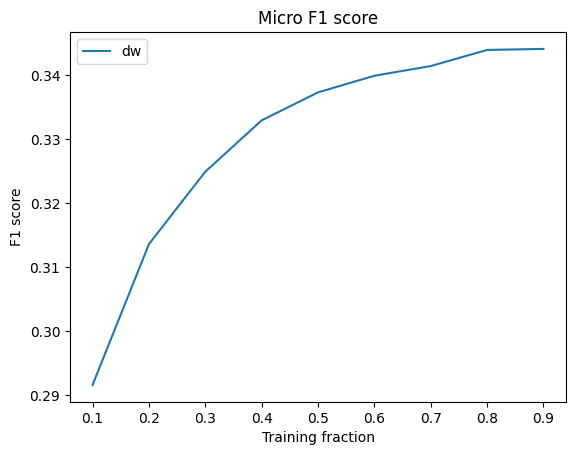

In [33]:
# plot the micro and macro f1 scores for dw and n2v against training fraction
plt.plot(training_fraction, micro_f1_scores_dw, label='dw')
# plt.plot(training_fraction, micro_f1_scores_n2v, label='n2v')
plt.legend()
plt.title('Micro F1 score')
plt.xlabel('Training fraction')
plt.ylabel('F1 score')

Text(0, 0.5, 'F1 score')

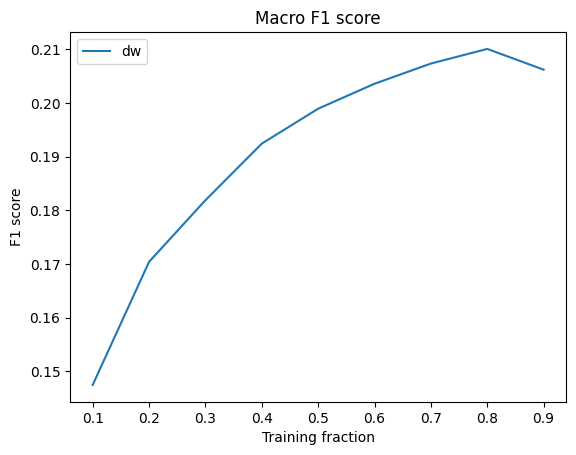

In [34]:
# plot the micro and macro f1 scores for dw and n2v against training fraction
plt.plot(training_fraction, macro_f1_scores_dw, label='dw')
# plt.plot(training_fraction, macro_f1_scores_n2v, label='n2v')
plt.legend()
plt.title('Macro F1 score')
plt.xlabel('Training fraction')
plt.ylabel('F1 score')